In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [4]:
# cleaned up IPPS dataset
df=pd.read_csv('data/IPPS_Data_Clean.csv', \
               dtype={'provider_id':str,'provider_zip_code':str, 'drg_id':str,'total_discharges':float})
df.head(3)

,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73
1,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14.0,15131.85,5787.57,4976.71
2,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24.0,37560.37,5434.95,4453.79


In [6]:
# GPS locations of every unique provider
dfprov=pd.read_csv('data/Providers_Geocode.csv',usecols=['provider_id','lat','lng'],dtype={'provider_id':str})
dfprov.head(3)

,provider_id,lat,lng
0,10001,31.216725,-85.363068
1,10005,34.221556,-86.159441
2,10006,34.793845,-87.683155


In [7]:
# State data (from Census.gov)
dfstates=pd.read_csv('data/NST-EST2015-alldata.csv',dtype={'POPESTIMATE2011':float})
dfstates = dfstates[5:56].reset_index(drop=True)
dfstates.head(3)

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015
0,40,3,6,1,Alabama,4779736,4780127,4785161,4801108.0,4816089,...,0.002295,-0.193196,0.381066,0.582002,-0.467369,1.030015,0.826644,1.383282,1.724718,0.712594
1,40,4,9,2,Alaska,710231,710249,714021,722720.0,731228,...,-1.173489,-1.946424,-3.915107,-14.438910,-10.407475,0.931274,1.818497,-0.757148,-11.271709,-6.881838
2,40,4,8,4,Arizona,6392017,6392307,6408208,6468732.0,6553262,...,1.327489,5.245740,3.905473,6.219955,6.776501,3.290378,7.337279,6.123606,8.761352,9.335208


In [8]:
totalpop = dfstates.POPESTIMATE2011.sum()
totalpop

311718857.0

In [10]:
dfpop = dfstates[['NAME','POPESTIMATE2011','RBIRTH2011','RDEATH2011']]

# Dataframe that lists states and their abbreviations
abbrev = pd.read_csv('data/states.csv')
abbrev = abbrev.rename(columns={'State':'NAME','Abbreviation':'provider_state'})

dfpop = dfpop.merge(abbrev,on ='NAME')
dfpop = dfpop[['provider_state','POPESTIMATE2011','RBIRTH2011','RDEATH2011']]
dfpop.head()

,provider_state,POPESTIMATE2011,RBIRTH2011,RDEATH2011
0,AL,4801108.0,12.453020,10.183524
1,AK,722720.0,16.302173,5.467931
2,AZ,6468732.0,13.373364,7.478795
3,AR,2938538.0,13.119074,10.041748
4,CA,37700034.0,13.587606,6.356202


In [29]:
# Combines all into one dataframe
dftot = df.merge(dfprov, on='provider_id')
dftot = dftot.merge(dfpop, on='provider_state')
#dftot = dftot.drop([list(dftot.columns)[1]]+list(dftot.columns)[3:5]+list(dftot.columns)[11:13],axis=1)
dftot = dftot.drop(['drg_definition','provider_id','provider_name', \
                    'provider_street_address','provider_zip_code'],axis=1)
dftot.head(3)

,drg_id,provider_city,provider_state,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,lat,lng,POPESTIMATE2011,RBIRTH2011,RDEATH2011
0,039,DOTHAN,AL,AL - Dothan,91.0,32963.07,5777.24,4763.73,31.216725,-85.363068,4801108.0,12.45302,10.183524
1,057,DOTHAN,AL,AL - Dothan,38.0,20312.78,4894.76,3865.50,31.216725,-85.363068,4801108.0,12.45302,10.183524
2,064,DOTHAN,AL,AL - Dothan,84.0,38820.39,10260.21,9167.08,31.216725,-85.363068,4801108.0,12.45302,10.183524


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [31]:
le = LabelEncoder()

state_enc = le.fit_transform(dftot.provider_state)
city_enc = le.fit_transform(dftot.provider_city)
refreg_enc = le.fit_transform(dftot.hospital_referral_region_description)

dftot['provider_state'] = state_enc
dftot['provider_city'] = city_enc
dftot['hospital_referral_region_description'] = refreg_enc

dftot.head()

,drg_id,provider_city,provider_state,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,lat,lng,POPESTIMATE2011,RBIRTH2011,RDEATH2011
0,039,454,1,2,91.0,32963.07,5777.24,4763.73,31.216725,-85.363068,4801108.0,12.45302,10.183524
1,057,454,1,2,38.0,20312.78,4894.76,3865.50,31.216725,-85.363068,4801108.0,12.45302,10.183524
2,064,454,1,2,84.0,38820.39,10260.21,9167.08,31.216725,-85.363068,4801108.0,12.45302,10.183524
3,065,454,1,2,169.0,27345.10,6542.08,5438.50,31.216725,-85.363068,4801108.0,12.45302,10.183524
4,066,454,1,2,33.0,17605.51,4596.39,3618.93,31.216725,-85.363068,4801108.0,12.45302,10.183524


In [32]:
proc = dftot.drg_id.unique()

In [33]:
inproc = proc[0]
print('drg_id: ',inproc)
dfcalc = dftot[dftot.drg_id == inproc].reset_index(drop=True)
dfX = dfcalc.drop(['drg_id','average_covered_charges','average_total_payments','average_medicare_payments'],axis=1)
#dfX.POPESTIMATE2011 = dfX.POPESTIMATE2011/totalpop
dfX.head()

drg_id:  039


,provider_city,provider_state,hospital_referral_region_description,total_discharges,lat,lng,POPESTIMATE2011,RBIRTH2011,RDEATH2011
0,454,1,2,91.0,31.216725,-85.363068,4801108.0,12.45302,10.183524
1,177,1,1,14.0,34.221556,-86.159441,4801108.0,12.45302,10.183524
2,582,1,1,24.0,34.793845,-87.683155,4801108.0,12.45302,10.183524
3,162,1,1,25.0,33.596457,-86.667650,4801108.0,12.45302,10.183524
4,13,1,1,18.0,33.252444,-86.813555,4801108.0,12.45302,10.183524


In [34]:
dfY = dfcalc.average_covered_charges

In [35]:
lm = LinearRegression()
lm.fit(dfX,dfY)

pd.DataFrame({'features':dfX.columns,'coefficients':lm.coef_})

,coefficients,features
0,-0.378081,provider_city
1,-97.650353,provider_state
2,1.380426,hospital_referral_region_description
3,-123.173973,total_discharges
4,-601.152950,lat
5,-300.160632,lng
6,0.000504,POPESTIMATE2011
7,-2317.253228,RBIRTH2011
8,211.544444,RDEATH2011


In [36]:
lm.score(dfX,dfcalc.average_covered_charges)

0.28030314596377437

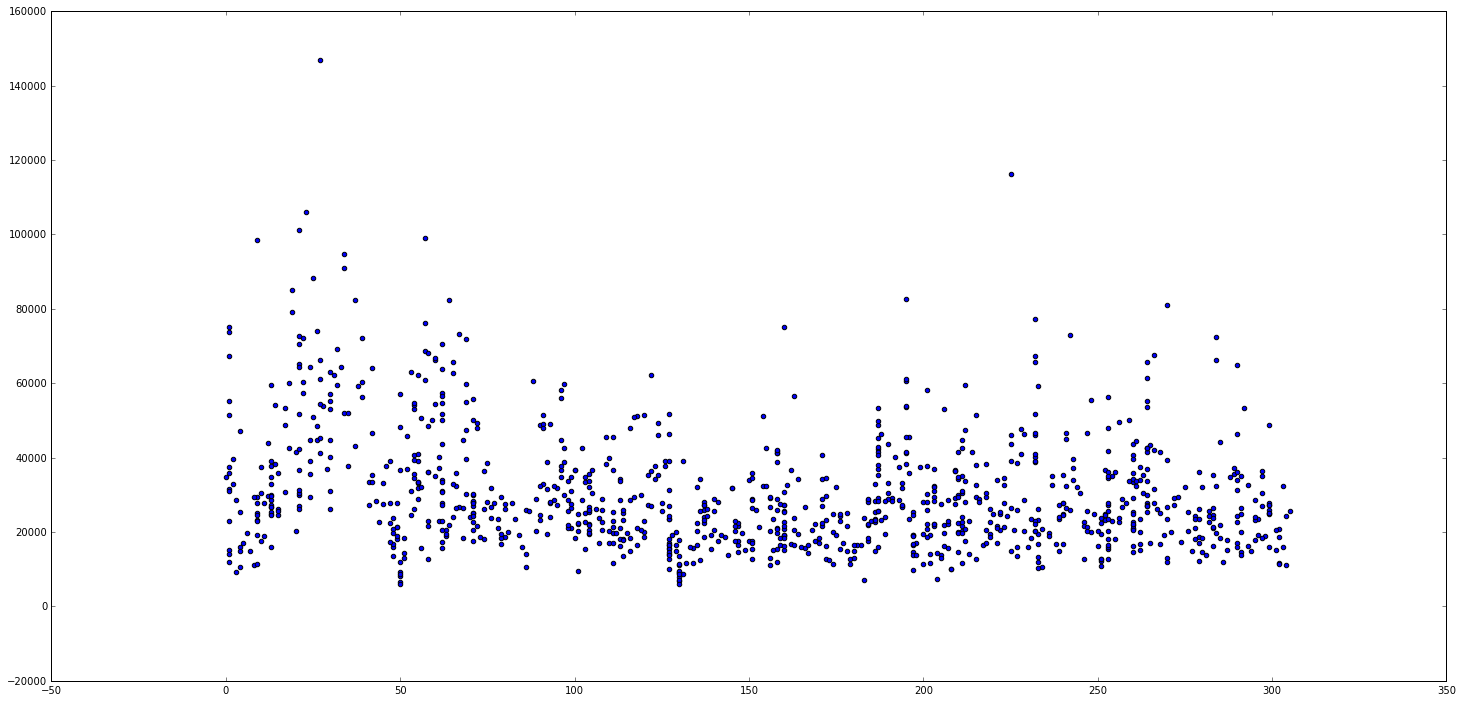

In [37]:
plt.figure(figsize=(25,12))
plt.scatter(dfcalc.hospital_referral_region_description,dfcalc.average_covered_charges)

In [46]:
inproc = proc[1]
print('drg_id: ',inproc)
dfcalc = dftot[dftot.drg_id == inproc].reset_index(drop=True)
dfX = dfcalc.drop(['drg_id','average_covered_charges','average_total_payments','average_medicare_payments','lat','lng'],axis=1)
#dfX.POPESTIMATE2011 = dfX.POPESTIMATE2011/totalpop
dfX.head(2)

drg_id:  057


,provider_city,provider_state,hospital_referral_region_description,total_discharges,POPESTIMATE2011,RBIRTH2011,RDEATH2011
0,454,1,2,38.0,4801108.0,12.45302,10.183524
1,162,1,1,24.0,4801108.0,12.45302,10.183524


In [47]:
dfY = pd.qcut(dfcalc.average_covered_charges,4,labels=range(4))
dfY.head()

0    1
1    2
2    2
3    0
4    3
Name: average_covered_charges, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [52]:
rf = RandomForestRegressor(n_jobs=-1)
rf.n_estimators=10

rf.fit(dfX,dfY)
rf.score(dfX,dfY)

0.88276537807398758

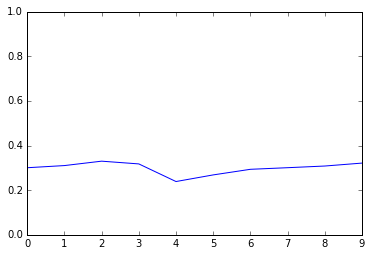

In [53]:
rf = RandomForestRegressor(n_jobs=-1)
rf.n_estimators=10
i = 0
it = 10
score = [0.0]*it

for i in range(it):
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, train_size=2./3)
    rf.fit(X_train,y_train)
    score[i] = rf.score(X_test,y_test)
    
plt.plot(score)
plt.ylim(0,1);

In [ ]:
# Combines all into one dataframe
dftot = df.merge(dfprov, on='provider_id')
dftot = dftot.merge(dfpop, on='provider_state')
dftot = dftot.drop(dftot.columns[0:4].union(dftot.columns[6:7]),axis=1)
dftot.head(3)

In [ ]:
#ohe = OneHotEncoder()
df_ohe = pd.get_dummies(dftot, columns=['provider_city','provider_state','hospital_referral_region_description'], dummy_na=True)
df_ohe.head()

In [ ]:
inproc = proc[1]
print('drg_id: ',inproc)
dfcalc = df_ohe[df_ohe.drg_id == inproc].reset_index(drop=True)
dfX = dfcalc.drop(['drg_id','average_covered_charges','average_total_payments','average_medicare_payments'],axis=1)
#dfX.POPESTIMATE2011 = dfX.POPESTIMATE2011/totalpop
dfX.head(2)

In [ ]:
dfY = pd.qcut(dfcalc.average_covered_charges,6,labels=range(6))
dfY.head()

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
rf.n_estimators=100
i = 0
it = 10
score = [0.0]*it

for i in range(it):
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, train_size=2./3)
    rf.fit(X_train,y_train)
    score[i] = rf.score(X_test,y_test)
    
plt.plot(score)
plt.ylim(0,1);

In [ ]:
dftot.head()